# SQLAlchemy: Surf Up!

In [34]:
# Set up dependeciesb
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import numpy as np
import pandas as pd
import datetime as dt

## Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


# Reflect Tables into SQLAlchemy ORM

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)
inspector=inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session=Session(engine)

### Explore the data in the each class

In [7]:
#To inspect the columns for each table un the data base: Measurement
for column in inspector.get_columns('measurement'):
    print(f'{column["name"]}, {column["type"]} ')

id, INTEGER 
station, TEXT 
date, TEXT 
prcp, FLOAT 
tobs, FLOAT 


In [8]:
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [9]:
#To inspect the columns for each table un the data base: Measurement
for column in inspector.get_columns('station'):
    print(f'{column["name"]}, {column["type"]} ')

id, INTEGER 
station, TEXT 
name, TEXT 
latitude, FLOAT 
longitude, FLOAT 
elevation, FLOAT 


In [96]:
engine.execute('SELECT * FROM station LIMIT 15').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [27]:
engine.execute("""
SELECT measurement.date, measurement.prcp, station.name 
FROM measurement 
INNER JOIN station ON 
measurement.station=station.station
WHERE measurement.date=='2010-01-01'
""").fetchall()

[('2010-01-01', 0.08, 'WAIKIKI 717.2, HI US'),
 ('2010-01-01', 0.28, 'KANEOHE 838.1, HI US'),
 ('2010-01-01', 0.21, 'UPPER WAHIAWA 874.3, HI US'),
 ('2010-01-01', 0.15, 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('2010-01-01', 0.15, 'WAIHEE 837.5, HI US'),
 ('2010-01-01', 0.05, 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('2010-01-01', 0.14, 'MANOA LYON ARBO 785.2, HI US')]

In [28]:
engine.execute("""
SELECT measurement.date, measurement.prcp, station.name 
FROM measurement 
INNER JOIN station ON 
measurement.station=station.station
WHERE station.name=='WAIKIKI 717.2, HI US'
LIMIT 5
""").fetchall()

[('2010-01-01', 0.08, 'WAIKIKI 717.2, HI US'),
 ('2010-01-02', 0.0, 'WAIKIKI 717.2, HI US'),
 ('2010-01-03', 0.0, 'WAIKIKI 717.2, HI US'),
 ('2010-01-04', 0.0, 'WAIKIKI 717.2, HI US'),
 ('2010-01-06', None, 'WAIKIKI 717.2, HI US')]

# Exploratory Climate Analysis

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
## Calculate the date 1 year ago from the last data point in the database
last_day=(
     session
    .query(Measurement.date)
    .order_by(Measurement.date.desc())
    .first()
)
#auxiliar to calculate the last 12 months (a year or 365 days)
target=dt.datetime.strptime(last_day[0],'%Y-%m-%d')-dt.timedelta(days=365)

print(f'''
      last data point: {last_day[0]}
      12 months of the last data point: {target.strftime('%Y-%m-%d')}''')


      last data point: 2017-08-23
      12 months of the last data point: 2016-08-23


## Plot precipation by day

In [15]:
# Perform a query to retrieve the data and precipitation scores
query_target=(
    session
    .query(Measurement.date, func.avg(Measurement.prcp))
    .filter(Measurement.date>=target).all()
)


In [93]:
# Save the query results as a Pandas DataFrame and set the index to the date column
Precipitation_byday=pd.DataFrame(query_target, columns=['Date', 'Precipation'])
Precipitation_byday=Precipitation_byday.set_index('Date')

# Sort the dataframe by date
Precipitation_byday=Precipitation_byday.sort_index(ascending=True)
Precipitation_byday.head()

,Precipation
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


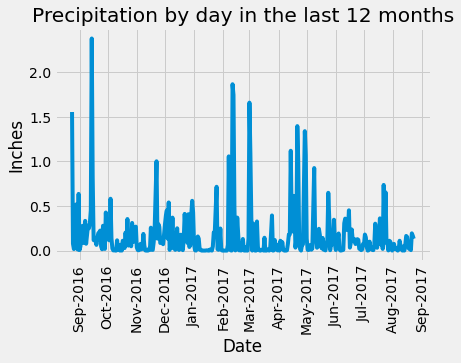

In [118]:
# Use Pandas Plotting with Matplotlib to plot the data
idx=pd.date_range(Precipitation_byday.index[0],Precipitation_byday.index[-1])

fig, ax=plt.subplots()
ax.plot(idx, Precipitation_byday['Precipation'])

# format the ticks
ax.xaxis.set_major_locator(mdates.MonthLocator()) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y')) 


## format titles
plt.title('Precipitation by day in the last 12 months')
plt.xlabel("Date")
plt.ylabel("Inches")

plt.xticks(rotation=90)
plt.show()



In [114]:
idx

DatetimeIndex(['2016-08-24', '2016-08-25', '2016-08-26', '2016-08-27',
               '2016-08-28', '2016-08-29', '2016-08-30', '2016-08-31',
               '2016-09-01', '2016-09-02',
               ...
               '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17',
               '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
               '2017-08-22', '2017-08-23'],
              dtype='datetime64[ns]', length=365, freq='D')

## Plot precipitation

In [131]:
# Perform a query to retrieve the data and precipitation scores
query_target_prcp=(
    session
    .query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date>=target).all()
)


In [133]:
# Save the query results as a Pandas DataFrame and set the index to the date column
Precipitation_dt=pd.DataFrame(query_target_prcp, columns=['Date', 'Precipation'])
Precipitation_dt=Precipitation_dt.set_index('Date')
Precipitation_dt=Precipitation_dt.dropna()

# Sort the dataframe by date
Precipitation_dt=Precipitation_dt.sort_index(ascending=True)
Precipitation_dt.head()

,Precipation
Date,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15


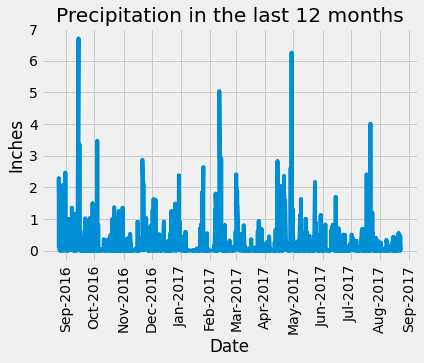

In [136]:
# Use Pandas Plotting with Matplotlib to plot the data
dta_aux=[dt.datetime.strptime(Precipitation_dt.index[i],'%Y-%m-%d').date() for i in range(len(Precipitation_dt.index))]

fig, ax_dt=plt.subplots()
ax_dt.plot(dta_aux, Precipitation_dt['Precipation'])

# format the ticks
ax_dt.xaxis.set_major_locator(mdates.MonthLocator()) 
ax_dt.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y')) 


## format titles
plt.title('Precipitation in the last 12 months')
plt.xlabel("Date")
plt.ylabel("Inches")

plt.xticks(rotation=90)
plt.show()



### Summary statistics

In [137]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Precipitation_byday.describe()

,Precipation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [138]:
Precipitation_dt.describe()

,Precipation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [ ]:
# Design a query to show how many stations are available in this dataset?


In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
